In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, learning_curve, GridSearchCV

import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor
from xgboost import XGBRegressor

## Introduction and EDA:

Here is our data set. It gives us inforamtion about second hand cars with their prices. The objective of this project is based on the inforamtion we have to make a good enough model that predicts the prices of cars.

In [2]:
data_set = pd.read_csv('train.csv')
data_set.head()

,Unnamed: 0,id,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,lat,long,posting_date,price
0,121610,7309831550,2007.0,infiniti,m45,excellent,NaN,gas,214740.0,clean,automatic,rwd,NaN,sedan,black,ga,34.139588,-83.971135,2021-04-20T11:46:13-0400,7995
1,395646,7317007429,2008.0,cadillac,escalade,NaN,NaN,gas,170276.0,clean,automatic,NaN,NaN,SUV,black,wa,47.756950,-122.212230,2021-05-04T16:16:32-0700,14999
2,236366,7309202024,2003.0,lexus,es,NaN,NaN,gas,176910.0,clean,automatic,fwd,NaN,sedan,NaN,nc,34.209703,-77.843995,2021-04-19T10:07:58-0400,5995
3,66001,7306341714,2017.0,bmw,320i,excellent,NaN,gas,41000.0,clean,automatic,4wd,NaN,SUV,NaN,ca,33.811000,-117.849300,2021-04-13T13:05:06-0700,0
4,320855,7307880118,2008.0,toyota,rav4,good,6 cylinders,gas,138900.0,clean,automatic,4wd,full-size,SUV,silver,pa,40.143550,-76.597071,2021-04-16T15:22:02-0400,7995


The first thing that i notice is that there are values with strange ranges. For example the prices of some cars are either `0$` with perfect condition or unrealisticly big price. So i think it will be a great idea to set a reasonable price range. I choose it to be between `400$` and `500 000$` because `99.99% ` of the data is in this span. Althoug there are not much cars above 100K i set the upper border to 500K so our model can learn how to predict even more expensive cars.  

In [3]:
data_set['price'].nlargest()

239819    3736928711
33858     3024942282
64710     1410065407
158821    1234567890
186472     135008900
Name: price, dtype: int64

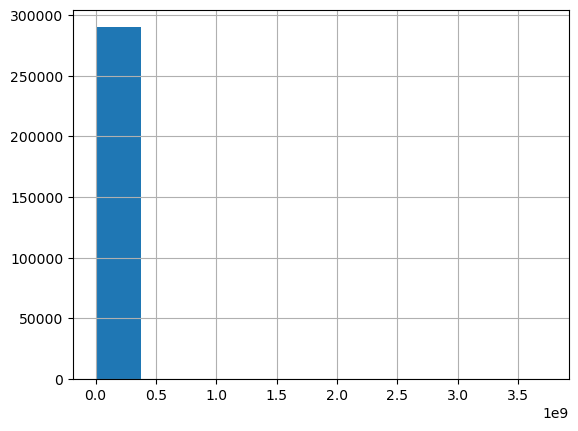

In [4]:
data_set['price'].hist();

In [5]:
# Here i create  a reasonable price range
data_set = data_set[(data_set['price'] >= 400) & (data_set['price'] <= 500_000)]

I decided to plot the prices of the cars to `100 000$` just to have better visulal of the histogram because there are only 370 cars more expensive than that.

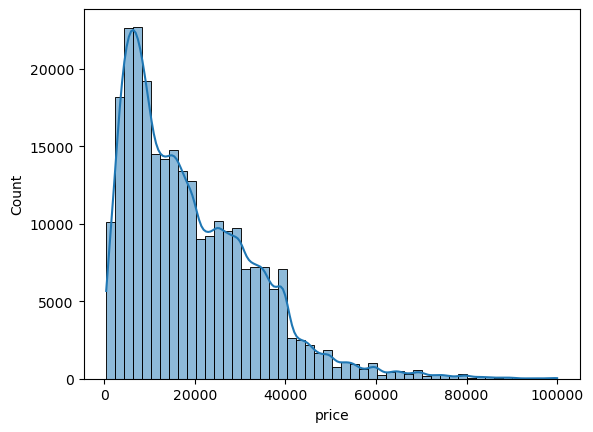

In [6]:
most_of_the_data = data_set[data_set['price'] <= 100_000]

sns.histplot(most_of_the_data, x='price',bins=50, kde=True);

Now below we have a scatter plot of the odometers and the prices. What i noticed here is that there are cars with 10 milion kilometers. So the first reason that i set the border to be 999K is that a real odometer can only reach this value after that it restarts and secondly there aren't much cars in the real world that can travel up to 10 milion kilometers so i consider that there might be added one more 0 by accident.

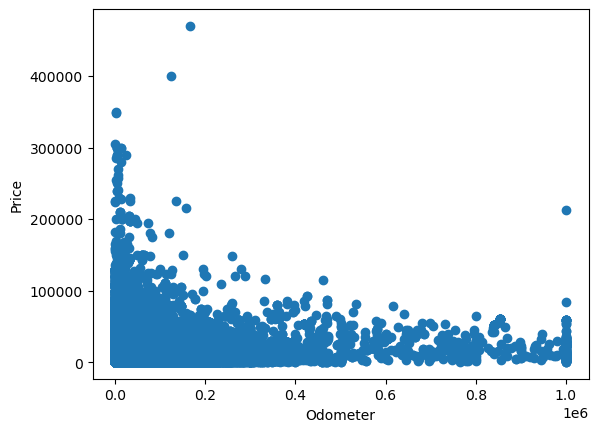

In [7]:
data_set = data_set[data_set['odometer'] <= 999_999]
plt.scatter(data_set['odometer'], data_set['price']);
plt.xlabel('Odometer')
plt.ylabel('Price')
plt.show()

Below i plot the years of the cars with the prices to see if there is a dependence between them. Here i also make a range of the year because it says there are cars from 1900 year. The reason i don't use them is that cars were not that widespread at the time and if there is by chance a car this old it won't be this cheap no matter its condition.

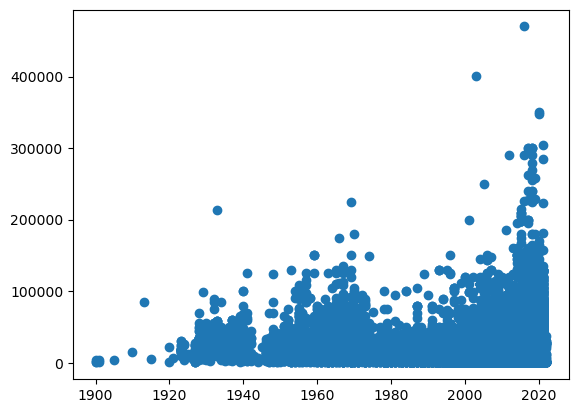

In [8]:
plt.scatter(data_set['year'], data_set['price']);

In [9]:
data_set['year'].nsmallest()

201059    1900.0
243698    1900.0
249023    1900.0
81925     1901.0
219439    1901.0
Name: year, dtype: float64

In [10]:
data_set = data_set[data_set['year'] >= 1925]

## Data preprocessing:

First i will drop the values that won't affect the price of the cars and have low correlation with it. Also i will drop columns with too many missing values and i can't fill them accurately

In [11]:
data_set.isna().sum()

Unnamed: 0           0
id                   0
year                 0
manufacturer      9997
model                0
condition        98296
cylinders       106487
fuel              1422
odometer             0
title_status      4592
transmission         0
drive            79766
size            188987
type             56385
paint_color      75769
state                0
lat               2330
long              2330
posting_date         0
price                0
dtype: int64

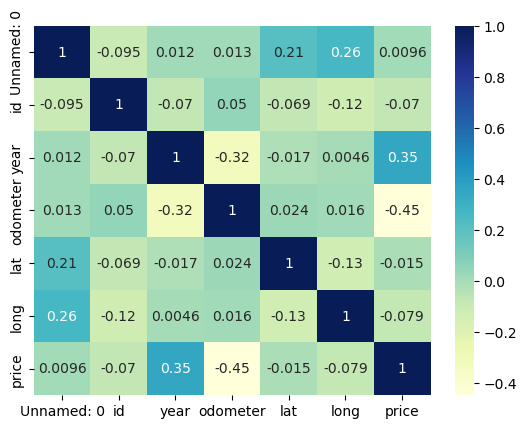

In [12]:
sns.heatmap(data_set.corr(), cmap="YlGnBu", annot=True);

In [13]:
def drop_columns(columns, df):
    """
    This function is short and simple. It recieves a list of the columns that need to be dropped and the dataframed that you 
    want to process it.
    """
    df = df.drop(columns, axis=1)
    return df

col_to_drop = ['Unnamed: 0', 'id', 'manufacturer', 'title_status', 'lat', 'long', 'posting_date', 'type', 'state', 'paint_color', 'size', 'drive']
data_set = drop_columns(col_to_drop, data_set)
data_set.head()

,year,model,condition,cylinders,fuel,odometer,transmission,price
0,2007.0,m45,excellent,NaN,gas,214740.0,automatic,7995
1,2008.0,escalade,NaN,NaN,gas,170276.0,automatic,14999
2,2003.0,es,NaN,NaN,gas,176910.0,automatic,5995
4,2008.0,rav4,good,6 cylinders,gas,138900.0,automatic,7995
5,2010.0,f150,excellent,8 cylinders,gas,156700.0,automatic,18300


## Handle the missing values:
The columns with the highest impact on the price are the year, condition, cylinders and transmission. So i think to handle the missing values in them by getting the median of the column that has the highest correlation with the one i want to fill and dont have is already clean and not artificially filled by me.

In [14]:
prices_by_condition = dict(data_set.groupby('condition')['price'].median())
prices_by_condition

{'excellent': 11995.0,
 'fair': 2800.0,
 'good': 20990.0,
 'like new': 14995.0,
 'new': 23000.0,
 'salvage': 2000.0}

In [15]:
data_set['condition'].value_counts()

good         82230
excellent    63660
like new     13498
fair          4423
new            739
salvage        364
Name: condition, dtype: int64

In [16]:
prices_by_condition = {
    2000: 'salvage',
    2800: 'fair',
    11995: 'excellent',
    14995: 'like new',
    20990: 'good',
    23000: 'new'
}

prices_checker = [2000, 2800, 11995, 14995, 20990, 23000]

for index, el in data_set.iterrows():
    if pd.isna(el['condition']):
        
        value = min(prices_checker, key=lambda x:abs(x-el['price']))
        
        for key, new_condition in prices_by_condition.items():
            if value == key:
                data_set.at[index, 'condition'] = new_condition

In [17]:
data_set.isna().sum()

year                 0
model                0
condition            0
cylinders       106487
fuel              1422
odometer             0
transmission         0
price                0
dtype: int64

In [18]:
cylinders_by_condition = dict(data_set.groupby('cylinders')['price'].median())
cylinders_by_condition

{'10 cylinders': 21995.0,
 '12 cylinders': 29500.0,
 '3 cylinders': 10122.0,
 '4 cylinders': 9300.0,
 '5 cylinders': 6800.0,
 '6 cylinders': 15900.0,
 '8 cylinders': 21000.0,
 'other': 13500.0}

In [19]:
prices_by_cyls = {
    6800: '5 cylinders',
    9296.5: '4 cylinders',
    10122: '3 cylinders',
    12999: 'other',
    15900: '6 cylinders',
    21000: '8 cylinders',
    21995: '10 cylinders',
    29500: '12 cylinders'
}

prices_checker_c = [6800, 9296.5, 10122, 12999, 15900, 21000, 21995, 29500]

for index, el in data_set.iterrows():
    if pd.isna(el['cylinders']):
        
        value = min(prices_checker_c, key=lambda x:abs(x-el['price']))
        
        for key, new_cyl in prices_by_cyls.items():
            if value == key:
                data_set.at[index, 'cylinders'] = new_cyl

In [20]:
data_set.head()

,year,model,condition,cylinders,fuel,odometer,transmission,price
0,2007.0,m45,excellent,5 cylinders,gas,214740.0,automatic,7995
1,2008.0,escalade,like new,6 cylinders,gas,170276.0,automatic,14999
2,2003.0,es,fair,5 cylinders,gas,176910.0,automatic,5995
4,2008.0,rav4,good,6 cylinders,gas,138900.0,automatic,7995
5,2010.0,f150,excellent,8 cylinders,gas,156700.0,automatic,18300


In [21]:
data_set.isna().sum()

year               0
model              0
condition          0
cylinders          0
fuel            1422
odometer           0
transmission       0
price              0
dtype: int64

I decided to drop the NA values of fuel, since its only 1422 values and don't have a creative way to fill them.

In [22]:
data_set.dropna(inplace=True)

In [23]:
label_encoder = LabelEncoder()

for label, content in data_set.items():
    if not pd.api.types.is_numeric_dtype(content):
        data_set[label] = label_encoder.fit_transform(data_set[label])
data_set.isna().sum()

year            0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
transmission    0
price           0
dtype: int64

### Spliting the data:

Now lets split the data. I pick the test size to be 10% since we have big dataset, and we need only 10k/15k test values. I used random state for reproducibility, and its 42 because of the book ''The Hitchhiker's Guide to the Galaxy'' :D

In [24]:
data = data_set.drop('price', axis=1)
target = data_set['price']

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.1, random_state=42)

### Training the model:

I decided to use Random Forest Regression. It is an ensemble machine learning technique used for regression tasks. It combines the power of multiple decision trees to make more accurate predictions on continuous target variables.

In [25]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

RandomForestRegressor()

### Evaluating the model:

Since i got this data set from a competition in kaggle, the evaluation metric was said to be R-Squared (R²). Here i just used score() function because as far as i know it does the same for regression models(I've read it somewhere and decided to trust it since the results are the same)

In [26]:
model.score(X_test, y_test)

0.8824681027347151

In [27]:
y_preds = model.predict(X_test)

mean_squared_error(y_test, y_preds)

28473824.928826872

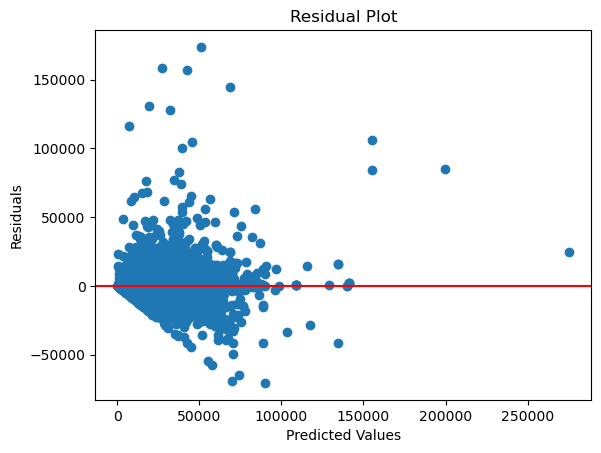

In [28]:
def plot_residuals(test, preds):
    residuals = test - preds
    plt.scatter(preds, residuals)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.axhline(y=0, color='r', linestyle='-')
    plt.title('Residual Plot')
    plt.show()
    
plot_residuals(y_test, y_preds)

The residual plot is one of the most commonly used plots to visualize the regression model's errors. It shows the difference between the actual and predicted values (residuals) plotted against the predicted values.
A good regression model will have residuals randomly scattered around the zero line. If the residuals have a pattern or are not randomly distributed, it indicates that the model is not performing well.

The plot above resembles to me like there is heteroscedasticity. So there are a few ways to fix it. I chosed to perform log transformation on the dependent variable because we don't have negative values and since the residuals exhibit heteroscedasticity or non-constant variance.

In [29]:
# Perfroming the log transformation, and replacing the transformed values in the dataset
log_price = np.log(data_set['price'])
data_set['price'] = log_price
data_set.head()

,year,model,condition,cylinders,fuel,odometer,transmission,price
0,2007.0,14494,0,4,2,214740.0,0,8.986572
1,2008.0,9954,3,5,2,170276.0,0,9.615739
2,2003.0,9911,1,4,2,176910.0,0,8.698681
4,2008.0,16912,2,5,2,138900.0,0,8.986572
5,2010.0,11113,0,6,2,156700.0,0,9.814656


Here i split the data again but now with the transformed prices.

In [30]:
data = data_set.drop('price', axis=1)
target = data_set['price']

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.1, random_state=42)

## Test different models and see which one performs best:


Now lets train and test our RandomForestRegressor on the new data.

In [31]:
rfr_model = RandomForestRegressor()
rfr_model.fit(X_train, y_train)

RandomForestRegressor()

The R^2 score have slightly went lower but what matters is that now our mean squared error went from 28 milion to just 0.09, and for MSE the closer the result is to 0 the better.

In [32]:
rfr_model.score(X_test, y_test)

0.8911498701884399

In [33]:
rfr_preds = rfr_model.predict(X_test)
mean_squared_error(y_test, rfr_preds)

0.09366947719148157

Now lets plot the residiuals and see if there is an improvement. And we see that it looks way better than before, the residuals are randomly scattered about zero with no systematic increase or decrease in variance . There are a few exceptions but can't be perfect

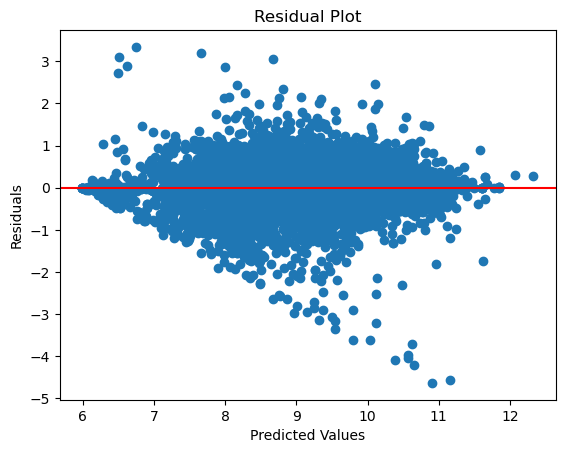

In [40]:
plot_residuals(y_test, rfr_preds)

The second model that we are going to use is XGBRegressor. Extreme Gradient Boosting is a powerful and popular machine learning algorithm known for its exceptional performance in various data science competitions and real-world applications. XGBRegressor is a specific implementation of the XGBoost algorithm designed for regression tasks.

In [35]:
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Here we can see that the XGB gives us also good results, but we can improve them by tunning the hyper parameters.

In [36]:
xgb_model.score(X_test, y_test)

0.8447856251668775

In [37]:
xgb_preds = xgb_model.predict(X_test)
mean_squared_error(y_test, xgb_preds)

0.13356758846673591

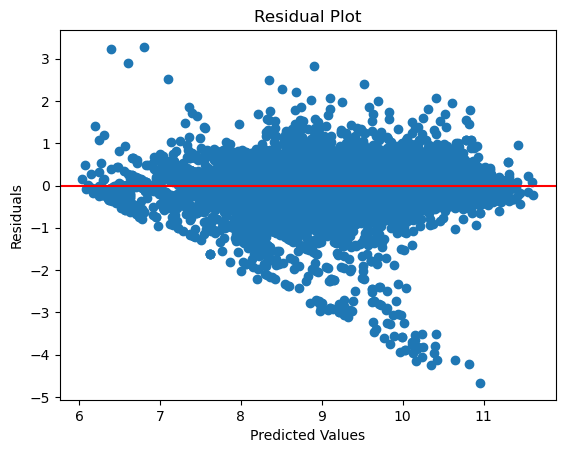

In [38]:
plot_residuals(y_test, xgb_preds)

Lets plot the learning curve and see if there is something wrong with our model. I will just plot the learning curve of the XGB model because its faster and won't take as much time as the one of Random Forest Regressor

In [39]:
def plot_learning_curve(reg, X, y):
    train_sizes, train_scores, val_scores = learning_curve(reg, X, y, 
                                                           train_sizes=np.linspace(0.1, 1.0, 10),
                                                           cv=5, scoring='neg_mean_squared_error')
    
    train_mean = -np.mean(train_scores, axis=1)
    val_mean = -np.mean(val_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training error')
    plt.plot(train_sizes, val_mean, label='Validation error')
    plt.xlabel('Number of Training Examples')
    plt.ylabel('Mean Squared Error')
    plt.title('Learning Curve')
    plt.legend()
    plt.show()

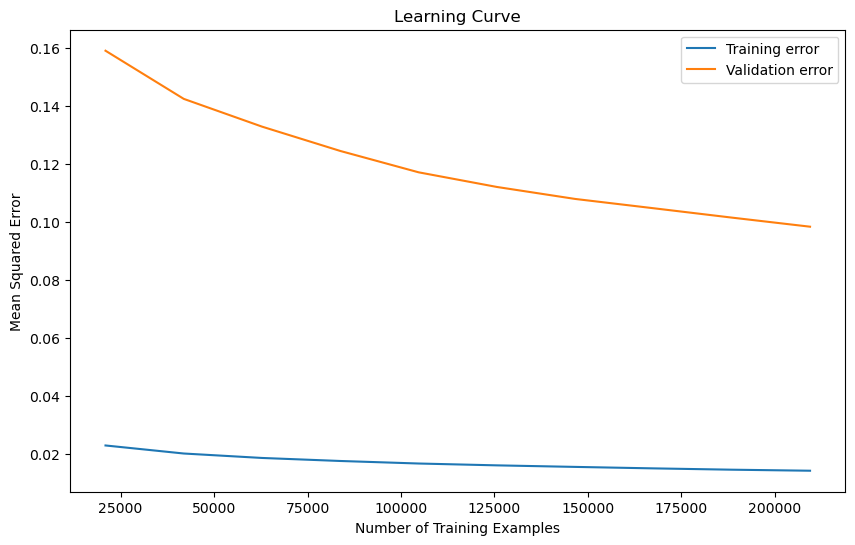

In [40]:
plot_learning_curve(rfr_model, data, target)

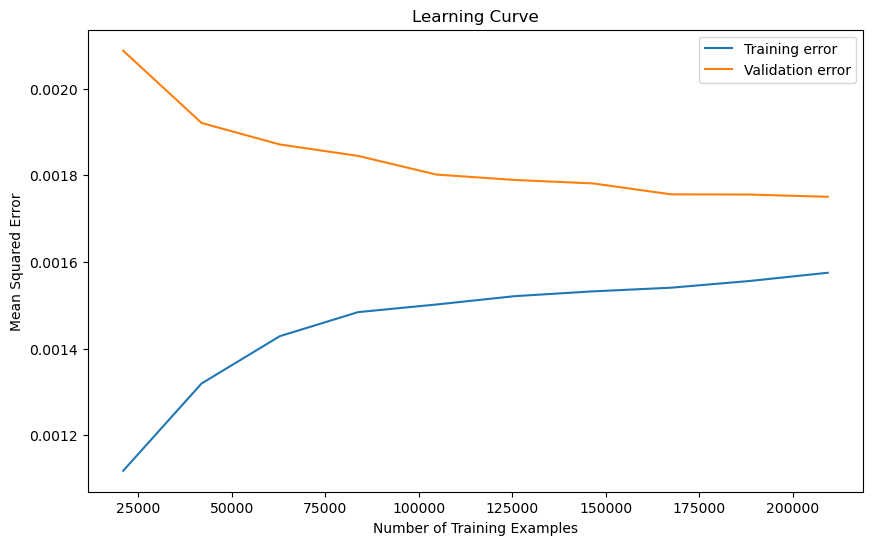

In [46]:
plot_learning_curve(xgb_model, data, target)

Seeing the learning curve we observe that there is room for improvment. The gap between the two lines indicates that there is variance but it isn't this significant

### Tune the hyperparameters

In [110]:
param_dist = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': np.arange(3, 11),
    'min_child_weight': np.arange(1, 11),
    'subsample': np.arange(0.8, 1.01, 0.1),
    'colsample_bytree': np.arange(0.8, 1.01, 0.1),
    'n_estimators': [100, 200, 300]
}

# Initialize RandomizedSearchCV with the XGBoost model and parameter distribution
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, 
                                   n_iter=10, cv=3, verbose=2)

# Perform the random search on the training data
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, min_child_weight=8, n_estimators=200, subsample=0.9; total time=  12.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, min_child_weight=8, n_estimators=200, subsample=0.9; total time=  12.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=9, min_child_weight=8, n_estimators=200, subsample=0.9; total time=  13.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=8, n_estimators=200, subsample=0.8; total time=   7.9s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=8, n_estimators=200, subsample=0.8; total time=   7.3s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=8, n_estimators=200, subsample=0.8; total time=   7.2s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=7, min_child_weight=6, n_estimators=100, subsample=0.9; total time= 

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          monotone_constraints=None,
                                      

In [111]:
# Get the best hyperparameters and best model
best_params = random_search.best_params_
best_model = random_search.best_estimator_

# Evaluate the best model on the test data
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Best Parameters: {best_params}")
print(f"Best Model Mean Squared Error: {mse}")

Best Parameters: {'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 6, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Best Model Mean Squared Error: 0.10246130665060464


In [112]:
best_model.score(X_test, y_test)

0.8809331826761319

By tunning the hyperparameters we see an inprovment in both the R^2 and MSE. There might be even better hyperparameters but these are the best we could find with our short but valueable RandomizedSearchCV :)

### Let's talk about the hyperparameters

* The subsample hyperparameter controls the fraction of the training data that is randomly sampled and used to grow each tree during the training process. It is expressed as a decimal number between 0 and 1.

* The n_estimators hyperparameter specifies the number of decision trees (estimators) that will be used in the ensemble. In gradient boosting, including XGBoost, the algorithm builds multiple decision trees sequentially, and n_estimators determines how many of these trees will be created.

* The min_child_weight hyperparameter controls the minimum sum of instance (sample) weights (hessian) needed in a child. It is used to add regularization to the algorithm and prevent overfitting by controlling the depth of the individual decision trees in the ensemble.

* The max_depth hyperparameter controls the maximum depth or depth limit of the individual decision trees in the ensemble. It specifies how many nodes or levels a tree can have. 

* The learning_rate hyperparameter is a critical parameter that controls the step size at which the algorithm adapts during training. It influences the contribution of each tree to the final prediction and plays a significant role in the overall performance of the model. 

* The colsample_bytree hyperparameter controls the fraction of features (columns) that are randomly sampled and used when constructing each individual decision tree during training. It's a form of feature subsampling designed to add diversity to the ensemble of trees. 